## Загружаем библиотеки

In [1]:
import numpy
import os
import pandas
import sklearn
import sklearn.model_selection
import sklearn.metrics

from matplotlib import pyplot
from sklearn.neural_network import MLPClassifier

## Загрузка и подготовка датасета

In [2]:
DATASET_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'healthcare-dataset-stroke-data.csv'))
dataset = pandas.read_csv(DATASET_PATH)

dataset.columns = dataset.columns.str.strip()

dataset.drop('id', axis=1, inplace=True)
dataset['bmi'].replace({'N/A': None}, inplace=True)
dataset['smoking_status'].replace({'Unknown': None}, inplace=True)
dataset['bmi'].fillna(dataset['bmi'].median(), inplace=True)
probabilities = dataset['smoking_status'].value_counts(normalize=True)
missing = dataset['smoking_status'].isnull()
dataset.loc[missing, 'smoking_status'] = numpy.random.choice(probabilities.index, size=len(dataset[missing]), p=probabilities.values)
dataset['gender'] = numpy.where(dataset['gender'] == 'Female', 1, 0)
dataset['ever_married'] = numpy.where(dataset['ever_married'] == 'Yes', 1, 0)
dataset['Residence_type'] = numpy.where(dataset['Residence_type'] == 'Urban', 1, 0)
dataset = pandas.get_dummies(dataset)
dataset_normalized = (dataset - dataset.mean(axis = 0)) / dataset.std(axis = 0)

## Разбиваем данные
75% данных попадут в обучающую выборку, остальный 25% в тестовую.

In [3]:
x = dataset_normalized.drop(['stroke'], axis=1)
y = dataset['stroke']
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.25, random_state=43)

## Обучаем классификатор

In [4]:
model = MLPClassifier(
    hidden_layer_sizes=(100,),
    solver='lbfgs',
    activation='logistic',
    random_state=42
)

In [5]:
%%time
model.fit(x_train, y_train)

Wall time: 995 ms


MLPClassifier(activation='logistic', random_state=42, solver='lbfgs')

## Проверяем качество классификатора

In [6]:
y_train_prediction = model.predict(x_train)
y_test_prediction = model.predict(x_test)

In [7]:
print('[Accuracy]\n')
print('Train: {}, Test: {}'.format(
    sklearn.metrics.accuracy_score(y_train, y_train_prediction),
    sklearn.metrics.accuracy_score(y_test, y_test_prediction)
))

[Accuracy]

Train: 1.0, Test: 0.903755868544601


## Подбор гипер параметров

### Подбор параметра альфа 

In [8]:
alpha_array = numpy.logspace(-3, 2, 16)
test_error = []
train_error = []

for alpha in alpha_array:
    model = MLPClassifier(
        alpha=alpha,
        hidden_layer_sizes=(100,),
        solver='lbfgs',
        activation ='logistic',
        max_iter=1000,
        random_state = 42
    )
    model.fit(x_train, y_train)

    y_train_prediction = model.predict(x_train)
    y_test_prediction = model.predict(x_test)

    test_error.append(numpy.mean(y_test != y_test_prediction))
    train_error.append(numpy.mean(y_train != y_train_prediction))

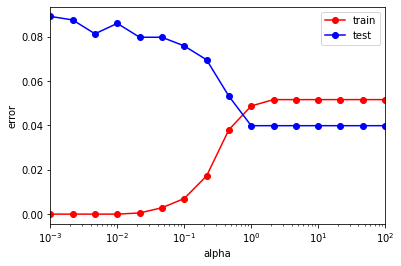

In [9]:
pyplot.semilogx(alpha_array, train_error, 'r-o', label='train')
pyplot.semilogx(alpha_array, test_error, 'b-o', label='test')
pyplot.xlim([numpy.min(alpha_array), numpy.max(alpha_array)])
pyplot.xlabel('alpha')
pyplot.ylabel('error')
pyplot.legend()

Отметим, что при значениях болших чем 1.0 практически не наблюдается изменение метрики.

In [10]:
min_test_error = numpy.min(test_error)
alpha_optimal = alpha_array[test_error == min_test_error][0]
print('Optimal alpha: {}'.format(alpha_optimal))

Optimal alpha: 1.0


### Подбор числа нейронов
Искать оптимальное чило нейронов будем при найденном оптимальном альфа.

In [11]:
neuron_count_array = numpy.linspace(1, 800, 24).astype(int)
test_error = []
train_error = []

for neuron_count in neuron_count_array:
    model = MLPClassifier(
        alpha=alpha_optimal,
        hidden_layer_sizes=(neuron_count,),
        solver='lbfgs',
        activation ='logistic',
        max_iter=1000,
        random_state = 42
    )
    model.fit(x_train, y_train)

    y_train_prediction = model.predict(x_train)
    y_test_prediction = model.predict(x_test)

    test_error.append(numpy.mean(y_test != y_test_prediction))
    train_error.append(numpy.mean(y_train != y_train_prediction))

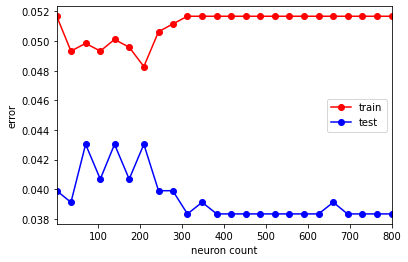

In [12]:
pyplot.plot(neuron_count_array, train_error, 'r-o', label='train')
pyplot.plot(neuron_count_array, test_error, 'b-o', label='test')
pyplot.xlim([numpy.min(neuron_count_array), numpy.max(neuron_count_array)])
pyplot.xlabel('neuron count')
pyplot.ylabel('error')
pyplot.legend()

In [13]:
min_test_error = numpy.min(test_error)
neuron_count_optimal = neuron_count_array[test_error == min_test_error][0]
print('Optimal neuron count: {}'.format(neuron_count_optimal))

Optimal neuron count: 313


При значения больших чем 300 значение метрики практически не изменяется, имеющиеся колебания достаточно незначительны.

### Итоговая классификация

In [14]:
model = MLPClassifier(
    alpha=alpha_optimal,
    hidden_layer_sizes=(neuron_count_optimal,),
    solver='lbfgs',
    activation='logistic',
    random_state=42
)

model.fit(x_train, y_train)

y_train_prediction = model.predict(x_train)
y_test_prediction = model.predict(x_test)

print('[Accuracy on optimized]\n')
print('Train: {}, Test: {}'.format(
    sklearn.metrics.accuracy_score(y_train, y_train_prediction),
    sklearn.metrics.accuracy_score(y_test, y_test_prediction)
))

[Accuracy on optimized]

Train: 0.9483298538622129, Test: 0.9616588419405321


### Матрица рассогласования

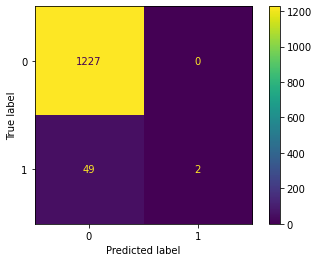

In [15]:
confusion_maxtrix = sklearn.metrics.confusion_matrix(y_test, y_test_prediction, labels=model.classes_)
confusion_maxtrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_maxtrix, display_labels=model.classes_)
confusion_maxtrix_display.plot()
pyplot.show()

### Выводы
* Подбор оптимальных значений гиперпараметров позволил получить ощутимый рост (около 6 процентных пунктов) метрики *accuracy* на тестовой выборке.
* Так как изначальная величина метрики *accuracy* на обучающей выборке была равна 1.0, то наблюдалось переобучение, за счёт устранения которого, по всей видимости и получен лучший резульат на тестовой выборке.